# F20/21NL 2025-2026: Self Attention and Transformers

Content of this tutorial is delivered during the 'F20NL/F21NL - Introduction to Natural Language Processing' course at Heriot-Watt University.

Transformers, introduced in the 2017 paper [*Attention is All You Need*](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) are the foundational neural network architecture for most state-of-the-art NLP models, including Large Language Models (LLMs) like ChatGPT, Gemini, and LLaMA. These models learn to predict the next token in a sequence by modeling relationships between tokens.

Alot of trendy architectures have come and gone for different modalities, like text, vision, or audio. While initially designed for machine translation, almost all fields are converging towards the Transformer.

Perhaps for the first time ever, there is a unified architecture that you can feed it basically anything, text, images or video, (think of it as a *trainable computer*) that is incredibly efficient to run in our hardware. It has simultaneously all these properties:

1. Expressive in the forward pass, where each token communicates with all other tokens and shares information (the self attention!)
2. Optimizable via simple methods like backpropagation + gradient descent
3. Efficient as it enables high parallelism compared to for example Recurrent Neural Networks where during training the hidden state is updated sequentially step by step as opposed to the Transformer where the operations are serialized





<div align="center">

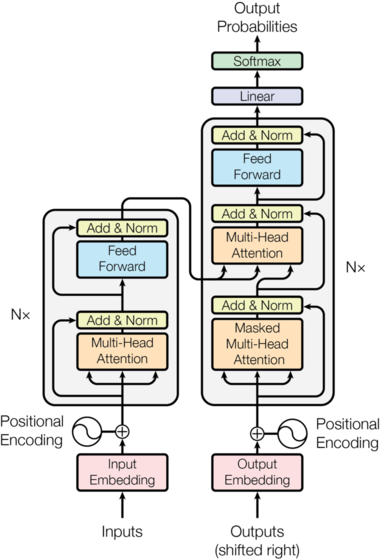

The original Transformer model shown above, follows an encoder-decoder architecture.

Here, the encoder (left) maps an input sequence tokens $\mathbf{x} = (x_1, x_2, \dots, x_n)$, to a sequence of continuous representations $\mathbf{z} = (z_1, z_2, \dots, z_n)$. Here, $\mathbf{z}$ is a latent representation of our input sequence that is given to the decoder (right) in order to complete it.

In other words, given $\mathbf{z}$, the decoder generates an output sequence of symbols $\mathbf{y} = (y_1, y_2, \dots y_m)$, one symbol at a time. Each time the model produces an output $y_i$, this symbol is appended at the input in order to generate the next symbol $y_{i+1}$. These models that use their previously generated input to produce the next one are called **auto-regressive.**


In this lab, we will draw from the original paper and [Andrej Karpathy's `nanoGPT`](https://github.com/karpathy/nanoGPT) to develop and train a Generatively Pretrained Transformer (GPT), more specifically following the [GPT2 architecture](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf). Our goal is to understand transformers as neural networks that learn to model word sequences effectively.


The GPT2 architecture is a decoder-only Transformer, i.e a simplified version of the above figure, where the decoder predicts the most likely next token given an input sequence.

In [1]:
!pip install torch altair pandas tqdm -U

In [2]:
import altair as alt
import pandas as pd
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
from pathlib import Path
from tqdm.notebook import tqdm

In [3]:
torch.manual_seed(1337)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
RUN_EXAMPLES = True

def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)

def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)

## Dataset Preparation

For the purposes of this lab, we are going to use 40,000 lines from various Shakespeare plays, featured in Andrej Karpathy’s blog post [*The Unreasonable Effectiveness of Recurrent Neural Networks*](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

In [5]:
!wget -q --show-progress https://raw.githubusercontent.com/karpathy/ng-video-lecture/refs/heads/master/input.txt -O input.txt

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   


In [6]:
BASE_DIR = Path().cwd()
DATASET_PATH = BASE_DIR / "input.txt"

assert DATASET_PATH.exists(), f"Dataset not found at {DATASET_PATH}"

with DATASET_PATH.open("r") as file:
    text = file.read()
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    print(text[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


## Character-level tokenization

Similar to the previous labs where we tried to create a bi-gram model for names, we are going to use a simple character-level tokenization


In [7]:
# create a mapping from characters to integers
chara2idx = {ch:i for i,ch in enumerate(chars)}
idx2chara = {i:ch for i,ch in enumerate(chars)}

def encode(characters: str) -> list[int]:
    """Encode a string into a list of integers."""
    return [chara2idx[chara] for chara in characters]


def decode(token_ids: list[int]) -> str:
    """Decode a list of token ids into a string."""
    return ''.join([idx2chara[token_id] for token_id in token_ids])


print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [8]:
# let's now encode the entire text dataset and store it into a torch.Tensor

data = torch.tensor(encode(text), dtype=torch.long)
print("\nLet's encode the entire dataset")
print(data.shape, data.dtype)
print(data[:100]) # the 1000 characters we looked at earier will to the GPT look like this


Let's encode the entire dataset
torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


## Determining Inputs and Outputs.


Our model is a decoder-only, i.e given an input sequence X, we expect the model to predict y. Recall that our bi-gram model accepted as input the previous character and tried to predict the one.

The input of the model is often referred to as **context**, or **prompt** (as you may have already seen). The maximum length of the input is often referred to as **context window** or **block size**.

Here, we define a block size of 8, i.e given up to 8 previous characters the model needs to predict the character in the sequence:


In [9]:
block_size = 8

x = text[:block_size]
y = text[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"Given {context} next token should be {target}.")

# Or using the token ids that we created
x = data[:block_size]
y = data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"Given {context.tolist()} next token should be {target}.")

Given F next token should be i.
Given Fi next token should be r.
Given Fir next token should be s.
Given Firs next token should be t.
Given First next token should be  .
Given First  next token should be C.
Given First C next token should be i.
Given First Ci next token should be t.
Given [18] next token should be 47.
Given [18, 47] next token should be 56.
Given [18, 47, 56] next token should be 57.
Given [18, 47, 56, 57] next token should be 58.
Given [18, 47, 56, 57, 58] next token should be 1.
Given [18, 47, 56, 57, 58, 1] next token should be 15.
Given [18, 47, 56, 57, 58, 1, 15] next token should be 47.
Given [18, 47, 56, 57, 58, 1, 15, 47] next token should be 58.


In [10]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
eval_data = data[n:]

def get_batch(
    data: torch.Tensor, batch_size: int = 4, block_size: int = 8
) -> tuple[torch.Tensor, torch.Tensor]:
    """Generate a small batch of data of inputs x and targets y."""
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

### Our good old Ngram Language Model

Below is the code for our ngram model that we used in the previous labs for the `__init__`, `forward`, and `generate` methods. By now this should be pretty much straightforward

In [11]:
class GPT(nn.Module):
    def __init__(self, vocab_size: int, n_embed: int = 64, block_size: int = 8) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.head = nn.Linear(n_embed, vocab_size)
        self.block_size = block_size

    def forward(
        self, inputs: torch.Tensor, targets: torch.Tensor | None = None
    ) -> tuple[torch.Tensor, torch.Tensor | None]:
        """Forward pass of the dump Ngram Language Model.

        Args:
            inputs (torch.Tensor): The input to the model
            targets (torch.Tensor): Optionally, the expected output from the model

        Returns:
            logits, loss (torch.Tensor, torch.Tensor | None): The logits from the head of
                the language model, and optionally the loss if the targets are provided
        """
        # inputs: torch.Tensor and targets are both (batch_size, sequence_length)
        # embedding the inputs into vectors: (batch_size, sequence_length, n_embed)
        embeddings = self.token_embedding_table(inputs)
        # 'probability distribution' for each token, for each element in the batch
        # (batch_size, sequence_length, vocab_size)
        logits = self.head(embeddings)

        loss = None
        if targets is not None:
            bsz, seq_len, vocab_size = logits.shape
            # Flattening the elements in the batch to compute the loss:
            # logits (bsz, seq_len, vocab_size) -> (bsz * seq_len, vocab_size)
            # targets: (bsz, seq_len) -> (bsz * seq_len)
            loss = F.cross_entropy(
                logits.view(bsz * seq_len, vocab_size), targets.view(bsz * seq_len)
            )

        return logits, loss

    @torch.inference_mode
    def generate(self, inputs: torch.Tensor, max_new_tokens: int) -> torch.Tensor:
        """Generation loop."""
        for _ in range(max_new_tokens):
            # Get the predictions, crop the inputs if they are longer than block_size
            logits, loss = self(inputs[:, -self.block_size :])
            # Focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # Sample from the distribution
            inputs_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # Append sampled index to the running sequence
            inputs = torch.cat((inputs, inputs_next), dim=1) # (B, T+1)
        return inputs

    @property
    def device(self) -> torch.device:
        """Determine which device to place the Tensors upon, CPU or GPU."""
        return self.token_embedding_table.weight.device

### Typical training loop

In [12]:
@torch.inference_mode()
def estimate_loss(
    model: torch.nn.Module,
    data: torch.Tensor,
    batch_size: int = 16,
    block_size: int = 32,
    eval_num_batches: int = 200,
) -> float:
    model.eval()
    total_loss = 0
    for k in range(eval_num_batches):
        X, Y = get_batch(data=data, batch_size=batch_size, block_size=block_size)
        logits, loss = model(X.to(model.device), Y.to(model.device))
        total_loss += loss.item()

    model.train()
    return total_loss / eval_num_batches

def train(
    model: torch.nn.Module,
    optimizer: torch.optim.AdamW,
    train_data: torch.Tensor,
    eval_data: torch.Tensor,
    batch_size: int = 16,
    block_size: int = 32,
    num_iterations: int = 5000,
    eval_interval: int = 500,
    eval_num_batches: int = 200,
) -> None:
    # print the number of parameters in the model
    print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")

    for iter in range(num_iterations):
        # sample a batch of training data
        xb, yb = get_batch(data=train_data, batch_size=batch_size, block_size=block_size)

        # Forward & backward pass
        logits, loss = model(xb.to(model.device), yb.to(model.device))
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        # Report the loss ever `eval_interval` iterations
        if iter % eval_interval == 0 or iter == num_iterations - 1:
            val_loss = estimate_loss(model, data=eval_data, batch_size=batch_size, block_size=block_size)
            print(f"Iter: {iter} train loss {loss:.4f} val loss {val_loss:.4f}")

In [13]:
vocab_size = len(chara2idx)
n_embed = 64
learning_rate = 1e-3
batch_size = 32
block_size = 32
num_iterations = 5000
eval_num_batches = 200
eval_interval = 500

# Create the model and move it to the proper device
model = GPT(vocab_size, n_embed, block_size)
model = model.to(device)
print(model)

# create a PyTorch optimizer, think of this as SGD on steroids
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# We should expect a similar loss compared to the implementation from previous labs
train(
    model=model,
    optimizer=optimizer,
    train_data=train_data,
    eval_data=eval_data,
    batch_size=batch_size,
    block_size=block_size,
    num_iterations=num_iterations,
    eval_interval=eval_interval,
    eval_num_batches=eval_num_batches,
)

GPT(
  (token_embedding_table): Embedding(65, 64)
  (head): Linear(in_features=64, out_features=65, bias=True)
)
0.008385 M parameters
Iter: 0 train loss 4.4474 val loss 4.4217
Iter: 500 train loss 2.5170 val loss 2.5466
Iter: 1000 train loss 2.4772 val loss 2.5056
Iter: 1500 train loss 2.4534 val loss 2.4934
Iter: 2000 train loss 2.4558 val loss 2.4950
Iter: 2500 train loss 2.4999 val loss 2.4865
Iter: 3000 train loss 2.4642 val loss 2.4909
Iter: 3500 train loss 2.4640 val loss 2.4921
Iter: 4000 train loss 2.4704 val loss 2.4915
Iter: 4500 train loss 2.4949 val loss 2.4894
Iter: 4999 train loss 2.4958 val loss 2.4928


In [14]:
# Certaintly not the best poet ever
print(decode(model.generate(torch.zeros((1, 1), dtype=torch.long).to(device), max_new_tokens=1000)[0].tolist()))


Of fon, nombrepewiste:
Thirevounowhagorcals the wed ous ere.
QUCOup mas cthowan wad t thathaprtou ed,
INinomyou EN'l mothep illascersus, hr: sthesof wifofanous harourtthend t h bre llad.
Teantvemy be byethu he Harit y ICHELO hatn thome talt.
What wem,
I inticed w ps hy he kns lig.

S: ced
Fise,
My halou thenosson, st f buswisactcarmeelontong t warethithe overers uieillf Sesstr be p'Thid shie t tient!
ARo
Fomorshequked thed fonerasethiatinad
Th:
Sathele! h tn me 'd, o s:
Fancomashtecr:
Anirild.


PI bothoed anthe bochises cate f on;
Ban INown: mapice wat n ut.
Woucoopes andre, led oth benar d,
F r.

I'dromy tise I:

QUSthourn ovee sthshell o ay iet, irs LUEd wonsmavextooure whonghore is n cout GRORCAs;
Foowocowithe seas

T: ' aicoure y syodelagack l.
PS:
AUSORO:
MENEin tprer,
wise pu m t t m!
Tht ty nnt thathan m ur arsed t RWhainofohe.
IN s ENCo t gris hry at bepoirerrean; sin t, lo F:
s!
I ccket CAl ow t s sou mun coknuf hond'sus s mand
Yowhrouarfoar eanorendapugearcord y co heaterea

## Attention



### The fundamentals behind self-attention
Before we dive deeper into the attention it is important to understand a mathematical trick which is a core component in the attention implementation. We are going to start with a toy example that will be very useful moving on.

By default, the attention mechanism will allow you to *connect* one token with every other token. However, in sequence modeling tasks, the token at position 5 should only communicate with the tokens at position 1,2,3, and 4, because the token 6,7 and 8 are future tokens in the sequence. In other words, the token at timestep $\tau$ should not communicate to any token in the future $\tau+{n}$.

**Information only flows from previous tokens to the current timestep, we do not get any information from the future tokens because we are trying to predict them.**

---


**Question** What is the easiest way for tokens to communicate with each other?


**Answer** The easiest way for the token at the 5th position is to average all preceding tokens including the current token. So we take all tokens starting until the 5th token and we average them out. This feature vector summarizes all information at the present moment in the context of all previous tokens.


Of course summation is an extremely lossy compression as we lose all information regarding spatial arrangement ($x_1 + x_2 + x_3$ = $x_3 + x_2 + x_1$) and we want to sequence modeling, meaning that order matters! (That is ok for now though)

In [15]:
torch.manual_seed(1337)
# We have a batch of sequences where each sequence has in total 8 tokens.
# Each of these tokens is a vector of two elements.
# Each of these vectors contains some information at a particular timestep in the sequence
batch_size, sequence_length, embedding_size = 4, 8, 2
batch = torch.randn(batch_size, sequence_length, embedding_size)

So our goal is to average all the vectors in all previous tokens including the current token:

$$
\mathrm{RunningAverage}[b, t] = mean_{i\le t}\big(batch[b, i] \big)
$$

for all timesteps $i$ in the sequence

In [16]:
running_average = torch.zeros((batch_size, sequence_length, embedding_size))
for b in range(batch_size):
    for t in range(sequence_length):
        # The previous chunk of tokens at timestep t are the tokens all the way until t+1
        previous_tokens = batch[b,: t+1]
        # Average all the previous tokens over the zero dimension (aka time)
        running_average[b, t] = torch.mean(previous_tokens, 0)

In [17]:
# Lets inspect this a little bit
# Notice how the running_average vector at timestep 2 is equal to the average of the first two vectors.
# The last vector is the average of all previous vectors
batch[0], running_average[0]

(tensor([[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]]),
 tensor([[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]))

Now of course this is extremely inefficient as we iterate every sequence in the batch and every element in each sequence.

As you should probably know by now, we can be very efficient using matrix multiplications and broadcasting!

In [18]:
torch.manual_seed(42)
a = torch.ones(3, 3)
b = torch.randint(0, 10, (3, 2)).float()
print(a)
print(b)
# Lets see what happens if we multiply the two matrices
print(a @ b)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])


We have a $3\times3$ matrix $a$ and a $3\times2$ matrix $b$ that we multiply together to get a matrix $3\times2$

How did we end up with these numbers after multiplication?
1. The first row of $a$ is multiplied by the first column of $b$ to and so we get $1\times2 + 1\times6+1\times6 = 14$
2. The second row of $a$ is multiplied by the first column of $b$ to and so we get $1\times2 + 1\times6+1\times6 = 14$
3. The first row of $a$ is multiplied by the second column of $b$ to and so we get $1\times7 + 1\times4+1\times4 = 16$

In [19]:
# Lets make a little bit more interesting
# Get the lower triangular part of a 3x3 matrix full of 1s
a = torch.tril(torch.ones(3, 3))
print(a)

# Lets see what happens if we multiply the two vectors
print(a @ b)

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
tensor([[ 2.,  7.],
        [ 8., 11.],
        [14., 16.]])


Multiplying now $a$ with $b$ we get the running sum of $b$ across all timesteps (rows of $b$). So we are pretty close to obtaining the running average efficiently since we now get the sums.

---
**Question**: How do we obtain the running average?


We can basically normalize the rows of $a$ so that they sum to 1 and then we get the running average of $b$

In [20]:
a = a / torch.sum(a, 1, keepdim=True)
print(a)
print(a @ b)

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [21]:
torch.sum(a, 1, keepdim=True).shape

torch.Size([3, 1])

In [22]:
weights = torch.tril(torch.ones(sequence_length, sequence_length))
weights = weights / weights.sum(1, keepdim=True)
# Batch matrix multiplication:
# (sequence_length, sequence_lenghth) @ (batch_size, sequence_length, sequence_lenghth) ->
# (batch_size, sequence_length, sequence_lenghth)
running_average2 = weights @ batch

# Lets verify that the implementation is the same
print(torch.allclose(running_average, running_average2, atol=1e-7))

True


So what happened here? We used a batch matrix multiplication to do a weighted aggregation specified by the `weights` with a triangular form, where the token at position $\tau$ is informed by only its preceding tokens


In the last modified version of our running average we will replace the weights by using the softmax:
1. We begin by initializing the weights to zero, and this can be viewed as the communication strength between two tokens, e.g, how much of a token from the past we want to average up.
2. Next, we "mask" out the tokens of the future with a very negative value.
3. We apply the softmax function that normalizes each row

In [23]:
tril = torch.tril(torch.ones(sequence_length, sequence_length))
weights = torch.zeros((sequence_length, sequence_length))
print(weights)
weights = weights.masked_fill(tril == 0, float("-inf"))
print(weights)
weights = weights.softmax(dim=-1)
print(weights)

# Batch matrix multiplication:
# (seq_len, seq_len) @ (bsz_size, seq_len, seq_len) -> (bsz_size, seq_len, seq_len)
running_average3 = weights @ batch

# Lets verify that the implementation is the same
print(torch.allclose(running_average, running_average3, atol=1e-7))

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000,

As a final preview of how attention works:

1. Attention is a fancy way of saying weighted averaging of information in a sequence.
2. In the final version of our running average example we have set the weights to zero and with a triangular shape. In practice the communication strength between tokens is going to be data dependent.
3. Tokens will start looking at each other and some tokens will find other tokens more or less interesting. Depending on their information, they will find each other interesting to different amounts.
4. We are also imposing a triangular mask to prevent previous tokens finding future tokens interesting
5. By normalizing and summing we aggregate the values of the tokens depending how interesting they find each other.

### Taking one step - data dependent weights


In the preview section we created "static" weights, i.e communication between each token in a sequence is independent of the value of that token. In this section we go one step deeper by constructing weights that are input dependent. The following attention mechanism is typically referred to as "Scaled Dot-Product Attention" and is illustrated in the following figure:


<div align="center">

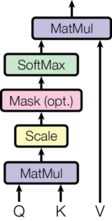

How can we make weights input dependent?
-- Just use a linear layer I guess.

More specifically, to make weights input dependent, every single token emits two vectors: a **query** with dimension $d_q$, and a **key** with dimension $d_k$. On a high level, the query vector represents what a token is looking for and the key vector corresponds to what information the token contains.


The communication strength between two tokens is the dot product between the queries and the keys. For sequence modeling, the query of the token at timestep 5 will dot product with all keys at time step 1,2,3, and 4.
If what we are looking for (the query) aligns with any of what the previous tokens contain (their keys), then the dot product between the query and that key will be very high.
Consequently, we will get more information from that specific token as opposed to any other token in the sequence.




In the preview section we multiplied the input sequence with the weights. In practice, the tokens emit a third vector (**value**) that is multiplied with the attention weights:


\begin{equation}
Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V
\end{equation}






---


**In summary**:


Every token emits three vectors (queries, keys, values)
1. Queries = What I am looking for
2. Keys = What do I contain
3. Values = What information do I have if you find me interesting (high dot product)


The softmax function will normalize all dot-product weights between 0 and 1. The larger the dot-product between a query and a key the higher the weight assigned to the value of that token!


**Important notes**:
1. Attention is a mechanism that allows tokens to communicate with each other in a data dependent way
2. Attention does not model positional information, i.e. it does not know the order of the tokens in the sequence. This is why we need to add positional encodings to the input embeddings.
3. Elements across batches do not communicate with each other.
4. In auto-regressive models, the attention mechanism is used to allow tokens to communicate with each other in a causal way, i.e. tokens can only communicate with tokens that came before them but attention is not limited to auto-regressive models, it can be used in any model where tokens need to communicate with each other.


6. The last element is the division by the square root of the head size ($d_k$). The reason for this is to preserve the variance of the keys and the queries resulting in weights that are fairly distributed. As we already saw, if we have weights with very high magnitude then the softmax converges to usually one-hot vectors by sharpening the input vector towards the max of that vector.

7. It is very common to have same dimensions for the embedding vectors, and all vectors within the attention, that is ``head_size = d_k = d_v = d_q``


#### Exercise 1: Implement the self-attention

In [24]:
class AttentionHead(nn.Module):
    def __init__(self, input_size: int, head_size: int, block_size: int, dropout: float = 0.1) -> None:
        super().__init__()
        # Linear layers for Key, Query, and Value projections:
        # These layers transform the input embeddings into
        # the key, query, and value representations (head_size).
        # We set bias=False as biases are often omitted in these projections for simplicity.
        self.key = nn.Linear(input_size, head_size, bias=False)
        self.query = nn.Linear(input_size, head_size, bias=False)
        self.value = nn.Linear(input_size, head_size, bias=False)

        # Causal Mask (Lower Triangular Matrix):
        # This is a non-trainable buffer registered with the module.
        # It's used to implement "causal" or "autoregressive" attention,
        # ensuring that a token at position `i` can only attend to tokens
        # at positions `j <= i`. This is crucial for tasks like language modeling.
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        # Dropout Layer:
        # Applied to the attention probabilities to regularize the model
        # and prevent co-adaptation of neurons, improving generalization.
        self.dropout = nn.Dropout(dropout)
        self.head_size = head_size

    def project_input_to_qkv(self, inputs: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Compute the key (k), query (q), and value (v) projections from the input."""
        k = self.key(inputs)
        q = self.query(inputs)
        v = self.value(inputs)

        return k, q, v

    def compute_scaled_dot_product_scores(self, q: torch.Tensor, k: torch.Tensor) -> torch.Tensor:
        """Calculates the dot products between queries and keys.

        Args:
            q (torch.Tensor): The queries of shape (bsz, seq_len, head_size)
            k (torch.Tensor): The keys of shape (bsz, seq_len, head_size)
        Returns:
            scores (torch.Tensor) The attention scores after dot-product + scaling
        """
        # Calculate dot products:
        # (bsz, seq_len, head_size) @ (bsz, head_size, seq_len) -> (bsz, seq_len, seq_len)
        # Pay attention to the shapes of the tensors that are being multiplied,
        # check if we need to reshape any of the q, k variables
        scores = q @ k.transpose(-2,-1)
        # Scale the scores by dividing with the square root of head_size_dim.
        scores = scores * self.head_size**-0.5
        return scores

    def apply_causal_mask(self, scores: torch.Tensor) -> torch.Tensor:
        """Applies a causal mask to the attention scores.

        This masking ensures that each token can only attend to previous tokens by setting their attention
        scores to negative infinite, so they become zero after softmax.

        Args:
            scores (torch.Tensor): The attention scores of shape (bsz, seq_len, seq_len)
        """
        # Apply the lower triangular mask. Wherever self.tril[:seq_len, :seq_len] is 0 (upper triangle),
        # set the corresponding score to negative infinity.
        seq_len = scores.shape[1]
        scores = scores.masked_fill(self.tril[:seq_len, :seq_len] == 0, float('-inf'))

        return scores

    def softmax_scores(self, scores: torch.Tensor) -> torch.Tensor:
        """Normalizes the attention scores using softmax."""

        scores = F.softmax(scores, dim=-1)
        return scores

    def weighted_averaging_the_values(self, scores: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
        """Perform weighted sum of values.

        Args:
            scores (torch.Tensor): The attention scores of shape (bsz, seq_len, seq_len)
            v (torch.Tensor): The value vectors of each token (bsz, seq_len, head_size)
        """
        # (bsz, seq_len, seq_len) @ (bsz, seq_len, head_size) -> (bsz, seq_len, head_size)
        return scores @ v

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """Forward pass of the attention module."""
        # Step 1: Every token in the input emits three vectors: q, k, v
        k, q, v = self.project_input_to_qkv(inputs=inputs)

        # Step 2: Compute dot products
        scores = self.compute_scaled_dot_product_scores(q, k)

        # Step 3: Apply causal mask to the attention scores
        scores = self.apply_causal_mask(scores)

        # Step 4: Apply the softmax function
        scores = self.softmax_scores(scores)

        # Step 5: Apply the dropouts
        scores = self.dropout(scores)

        # Step 7: perform the weighted aggregation of the values
        out = out = self.weighted_averaging_the_values(scores, v)
        return out

In [25]:
# Playground area
batch_size = 4
block_size = 4
input_size = 8
head_size = 2

# Initialize the Head module
torch.manual_seed(42)
# Set dropout to 0 for deterministic testing
head = AttentionHead(input_size, head_size, block_size, dropout=0.0)
x = torch.randn(batch_size, block_size, input_size)

output = head(x)

print(output.shape, output)

torch.Size([4, 4, 2]) tensor([[[ 0.1818, -0.3427],
         [ 0.1302, -0.3723],
         [ 0.1185, -0.2403],
         [ 0.0674, -0.1452]],

        [[ 0.2268, -0.0861],
         [ 0.1521,  0.0912],
         [-0.1097,  0.0442],
         [ 0.0356,  0.0243]],

        [[-0.2386,  0.0212],
         [ 0.0114,  0.2800],
         [ 0.3647, -0.0974],
         [ 0.5982, -0.1607]],

        [[-0.1633,  0.4592],
         [ 0.1111, -0.1425],
         [-0.3986,  0.0591],
         [-0.2842, -0.0881]]], grad_fn=<UnsafeViewBackward0>)


#### Test your implementation

**DO NOT MODIFY THE CODE BELOW IT IS ONLY FOR TESTING PURPOSES**

In [51]:
# @title
!wget -q https://github.com/f21nl-heriot-watt/labs_2025_2026-students/raw/refs/heads/main/tests/self_attn_transformers/attention_head_expected_output.pt?download=true -O attention_head_expected_output.pt
!wget -q https://github.com/f21nl-heriot-watt/labs_2025_2026-students/raw/refs/heads/main/tests/self_attn_transformers/attention_head_k.pt?download=true -O attention_head_k.pt
!wget -q https://github.com/f21nl-heriot-watt/labs_2025_2026-students/raw/refs/heads/main/tests/self_attn_transformers/attention_head_q.pt?download=true -O attention_head_q.pt
!wget -q https://github.com/f21nl-heriot-watt/labs_2025_2026-students/raw/refs/heads/main/tests/self_attn_transformers/attention_head_raw_scores.pt?download=true -O attention_head_raw_scores.pt
!wget -q https://github.com/f21nl-heriot-watt/labs_2025_2026-students/raw/refs/heads/main/tests/self_attn_transformers/attention_head_softmax_scores.pt?download=true -O attention_head_softmax_scores.pt
!wget -q https://github.com/f21nl-heriot-watt/labs_2025_2026-students/raw/refs/heads/main/tests/self_attn_transformers/attention_head_v.pt?download=true -O attention_head_v.pt
!wget -q https://github.com/f21nl-heriot-watt/labs_2025_2026-students/raw/refs/heads/main/tests/self_attn_transformers/attention_head_masked_scores.pt?download=true -O attention_head_masked_scores.pt

In [52]:
# @title
def test_attention_head_components() -> None:
    """
    Test the AttentionHead module's individual components and overall functionality.
    Provides detailed feedback for each step and raises an AssertionError on failure.
    """

    # Define common parameters
    batch_size = 16
    block_size = 16
    n_embd = 64
    head_size = 32

    # Initialize the Head module for testing
    torch.manual_seed(42) # for reproducibility
    head = AttentionHead(n_embd, head_size, block_size, dropout=0.0) # Set dropout to 0 for deterministic testing

    # Create dummy input data (same as used for generating expected outputs)
    x = torch.randn(batch_size, block_size, n_embd)
    B, T, C = x.shape

    print("--- Starting AttentionHead Component Tests ---")

    # --- Test 1: project_input_to_qkv ---
    print("\nTesting project_input_to_qkv...")
    k_student, q_student, v_student = head.project_input_to_qkv(x)

    k_expected = torch.load("attention_head_k.pt")
    q_expected = torch.load("attention_head_q.pt")
    v_expected = torch.load("attention_head_v.pt")

    # Assert shapes first
    expected_qkv_shape = (batch_size, block_size, head_size)
    assert k_student.shape == expected_qkv_shape, \
        f"FAILED: project_input_to_qkv - Key (k) shape mismatch! Expected {expected_qkv_shape}, got {k_student.shape}.\n" \
        "Hint: The output of a linear layer should have the shape (Batch, SequenceLength, HeadSize)."
    assert q_student.shape == expected_qkv_shape, \
        f"FAILED: project_input_to_qkv - Query (q) shape mismatch! Expected {expected_qkv_shape}, got {q_student.shape}.\n" \
        "Hint: The output of a linear layer should have the shape (Batch, SequenceLength, HeadSize)."
    assert v_student.shape == expected_qkv_shape, \
        f"FAILED: project_input_to_qkv - Value (v) shape mismatch! Expected {expected_qkv_shape}, got {v_student.shape}.\n" \
        "Hint: The output of a linear layer should have the shape (Batch, SequenceLength, HeadSize)."
    print("PASSED: project_input_to_qkv - All projection shapes match expected.")

    # Then assert values
    assert torch.allclose(k_student, k_expected, atol=1e-6), \
        "FAILED: project_input_to_qkv - Key (k) value mismatch!\n" \
        "Hint: Check your linear layer definitions for key, query, and value, and how you apply them to the input 'x'."
    print("PASSED: project_input_to_qkv - Key (k) values match expected.")

    assert torch.allclose(q_student, q_expected, atol=1e-6), \
        "FAILED: project_input_to_qkv - Query (q) value mismatch!\n" \
        "Hint: Ensure you are correctly projecting 'x' to 'q' using self.query."
    print("PASSED: project_input_to_qkv - Query (q) values match expected.")

    assert torch.allclose(v_student, v_expected, atol=1e-6), \
        "FAILED: project_input_to_qkv - Value (v) value mismatch!\n" \
        "Hint: Ensure you are correctly projecting 'x' to 'v' using self.value."
    print("PASSED: project_input_to_qkv - Value (v) values match expected.")
    print("PASSED: project_input_to_qkv - All projections (shapes and values) match expected.")


    # --- Test 2: compute_scaled_dot_product_scores ---
    print("\nTesting compute_scaled_dot_product_scores...")
    # Use the expected q and k for this test to isolate the function
    q_loaded = torch.load("attention_head_q.pt")
    k_loaded = torch.load("attention_head_k.pt")

    scores_student = head.compute_scaled_dot_product_scores(q_loaded, k_loaded)
    torch.save(scores_student, "attention_head_raw_scores.pt")
    scores_expected = torch.load("attention_head_raw_scores.pt")

    # Assert shape first
    expected_scores_shape = (batch_size, block_size, block_size)
    assert scores_student.shape == expected_scores_shape, \
        f"FAILED: compute_scaled_dot_product_scores - Scores shape mismatch! Expected {expected_scores_shape}, got {scores_student.shape}.\n" \
        "Hint: After (B,T,C) @ (B,C,T) should be (B,T,T). Check your transpose operation."
    print("PASSED: compute_scaled_dot_product_scores - Raw scores shape matches expected.")

    # Then assert values
    assert torch.allclose(scores_student, scores_expected, atol=1e-6), \
        "FAILED: compute_scaled_dot_product_scores - Attention scores value mismatch!\n" \
        "Hint: Double-check the dot product calculation (q @ k.transpose) and the scaling factor (C**-0.5)."
    print("PASSED: compute_scaled_dot_product_scores - Raw attention scores (shape and values) match expected.")


    # --- Test 3: apply_causal_mask ---
    print("\nTesting apply_causal_mask...")
    # Use the expected raw scores for this test
    raw_scores_loaded = torch.load("attention_head_raw_scores.pt")

    masked_scores_student = head.apply_causal_mask(raw_scores_loaded)
    torch.save(masked_scores_student, "attention_head_masked_scores.pt")
    masked_scores_expected = torch.load("attention_head_masked_scores.pt")

    # Assert shape first (should be same as raw scores)
    expected_masked_scores_shape = (batch_size, block_size, block_size)
    assert masked_scores_student.shape == expected_masked_scores_shape, \
        f"FAILED: apply_causal_mask - Masked scores shape mismatch! Expected {expected_masked_scores_shape}, got {masked_scores_student.shape}.\n" \
        "Hint: Masking should not change the tensor's shape."
    print("PASSED: apply_causal_mask - Masked scores shape matches expected.")

    # Then assert values
    assert torch.allclose(masked_scores_student, masked_scores_expected, atol=1e-6, equal_nan=True), \
        "FAILED: apply_causal_mask - Masked scores value mismatch!\n" \
        "Hint: Ensure you are correctly using `masked_fill` with `self.tril` to set future tokens to `float('-inf')`."
    print("PASSED: apply_causal_mask - Masked attention scores (shape and values) match expected.")


    # --- Test 4: softmax_scores ---
    print("\nTesting softmax_scores...")
    # Use the expected masked scores for this test
    masked_scores_loaded = torch.load("attention_head_masked_scores.pt")

    softmax_scores_student = head.softmax_scores(masked_scores_loaded)
    torch.save(softmax_scores_student, "attention_head_softmax_scores.pt")
    softmax_scores_expected = torch.load("attention_head_softmax_scores.pt")

    # Assert shape first (should be same as masked scores)
    expected_softmax_scores_shape = (batch_size, block_size, block_size)
    assert softmax_scores_student.shape == expected_softmax_scores_shape, \
        f"FAILED: softmax_scores - Softmax scores shape mismatch! Expected {expected_softmax_scores_shape}, got {softmax_scores_student.shape}.\n" \
        "Hint: Softmax operation should not change the tensor's shape."
    print("PASSED: softmax_scores - Softmax scores shape matches expected.")

    # Then assert values
    assert torch.allclose(softmax_scores_student, softmax_scores_expected, atol=1e-6), \
        "FAILED: softmax_scores - Softmax scores value mismatch!\n" \
        "Hint: Make sure you are applying `F.softmax` along the correct dimension (dim=-1)."
    print("PASSED: softmax_scores - Softmax-normalized attention scores (shape and values) match expected.")


    # --- Test 5: weighted_averaging_the_values ---
    print("\nTesting weighted_averaging_the_values...")
    # Use expected softmax scores and value projections for this test
    softmax_scores_loaded = torch.load("attention_head_softmax_scores.pt")
    v_loaded = torch.load("attention_head_v.pt")

    # Since dropout is 0 for testing, softmax_scores_loaded is effectively the input.
    aggregated_values_student = head.weighted_averaging_the_values(softmax_scores_loaded, v_loaded)
    torch.save(aggregated_values_student, "attention_head_expected_output.pt")
    final_output_expected = torch.load("attention_head_expected_output.pt")

    # Assert shape first
    expected_aggregated_values_shape = (batch_size, block_size, head_size)
    assert aggregated_values_student.shape == expected_aggregated_values_shape, \
        f"FAILED: aggregate_weighted_values - Aggregated output shape mismatch! Expected {expected_aggregated_values_shape}, got {aggregated_values_student.shape}.\n" \
        "Hint: The matrix multiplication (B,T,T) @ (B,T,C) should result in (B,T,C)."
    print("PASSED: aggregate_weighted_values - Aggregated output shape matches expected.")

    # Then assert values
    assert torch.allclose(aggregated_values_student, final_output_expected, atol=1e-6), \
        "FAILED: aggregate_weighted_values - Aggregated output value mismatch!\n" \
        "Hint: Check the matrix multiplication: `scores @ v`. The dimensions must align correctly."
    print("PASSED: aggregate_weighted_values - Weighted values aggregation (shape and values) match expected.")

    print("\n--- Starting Full AttentionHead Module Tests ---")

    # --- Full Module Test 1: Output Shape ---
    print("\nTesting full AttentionHead module (Output Shape)...")
    # Create a fresh input for the full forward pass test
    torch.manual_seed(42)
    x_full_test = torch.randn(batch_size, block_size, n_embd)
    output_student_full = head(x_full_test)

    expected_output_shape = (batch_size, block_size, head_size)
    assert output_student_full.shape == expected_output_shape, \
        f"FAILED: Full Module Output Shape - Expected {expected_output_shape}, got {output_student_full.shape}\n" \
        "Hint: The final output shape should be (Batch, SequenceLength, HeadSize)."
    print("PASSED: Full Module Output Shape - Correct shape.")

    # --- Full Module Test 2: Deterministic Output with Fixed Seed ---
    print("\nTesting full AttentionHead module (Deterministic Output)...")
    torch.manual_seed(42)
    head2 = AttentionHead(n_embd, head_size, block_size, dropout=0.0)
    x2 = torch.randn(batch_size, block_size, n_embd)
    output2 = head2(x2)

    # Re-run the first instance with the same seed to compare
    torch.manual_seed(42)
    head_initial = AttentionHead(n_embd, head_size, block_size, dropout=0.0)
    x_initial = torch.randn(batch_size, block_size, n_embd)
    output_initial = head_initial(x_initial)


    assert torch.allclose(output_initial, output2, atol=1e-6), \
        "FAILED: Full Module Deterministic Output - Running the module twice with the same seed and input yields different results.\n" \
        "Hint: Ensure all operations are deterministic and no random elements are present when dropout is 0. Check for in-place operations that might cause issues."
    print("PASSED: Full Module Deterministic Output - Consistent results with fixed seed.")

    # --- Full Module Test 3: Compare against Expected Final Output ---
    print("\nTesting full AttentionHead module (Against Pre-computed Expected Output)...")
    torch.manual_seed(42) # Ensure student's forward pass starts from the same state
    head_final_test = AttentionHead(n_embd, head_size, block_size, dropout=0.0)
    x_final_test = torch.randn(batch_size, block_size, n_embd)
    output_student_final = head_final_test(x_final_test)

    expected_final_output = torch.load("attention_head_expected_output.pt")

    # Assert shape first
    expected_final_output_shape = (batch_size, block_size, head_size)
    assert output_student_final.shape == expected_final_output_shape, \
        f"FAILED: Full Module Expected Output - Final output shape mismatch! Expected {expected_final_output_shape}, got {output_student_final.shape}.\n" \
        "Hint: The final output of the AttentionHead should be (Batch, SequenceLength, HeadSize)."
    print("PASSED: Full Module Expected Output - Final output shape matches expected.")

    # Then assert values
    is_output_close = torch.allclose(output_student_final, expected_final_output, atol=1e-6)
    assert is_output_close, \
        "FAILED: Full Module Expected Output - Your final AttentionHead output values do NOT match the pre-computed expected output.\n" \
        "Hint: This usually means one of your internal calculations (_project_input_to_qkv, _compute_scaled_dot_product_scores, _apply_causal_mask, _softmax_scores, _aggregate_weighted_values) or the overall flow in `forward` is incorrect."
    print("PASSED: Full Module Expected Output - Your full module output (shape and values) matches the pre-computed expected output. Great job!")

    print("\n--- All AttentionHead tests completed successfully! ---")


test_attention_head_components()

--- Starting AttentionHead Component Tests ---

Testing project_input_to_qkv...
PASSED: project_input_to_qkv - All projection shapes match expected.
PASSED: project_input_to_qkv - Key (k) values match expected.
PASSED: project_input_to_qkv - Query (q) values match expected.
PASSED: project_input_to_qkv - Value (v) values match expected.
PASSED: project_input_to_qkv - All projections (shapes and values) match expected.

Testing compute_scaled_dot_product_scores...
PASSED: compute_scaled_dot_product_scores - Raw scores shape matches expected.
PASSED: compute_scaled_dot_product_scores - Raw attention scores (shape and values) match expected.

Testing apply_causal_mask...
PASSED: apply_causal_mask - Masked scores shape matches expected.
PASSED: apply_causal_mask - Masked attention scores (shape and values) match expected.

Testing softmax_scores...
PASSED: softmax_scores - Softmax scores shape matches expected.
PASSED: softmax_scores - Softmax-normalized attention scores (shape and values)

### MultiHead Attention

In practice, each transformer block contains multiple self attention components concatenated together which is referred to as MultiHead attention. These attention heads operate in paralle across the input, by producing head-specific queries, keys, and values and applying the self attention operation on these inputs.
The reason for this is that we want our model to specialize in invididual things. Each attention head will become an **expert** as training progresses, for example a head might be more active on tokens that refer to noun entities in our sequence, while a different head may specialize on verbs!



<div align="center">

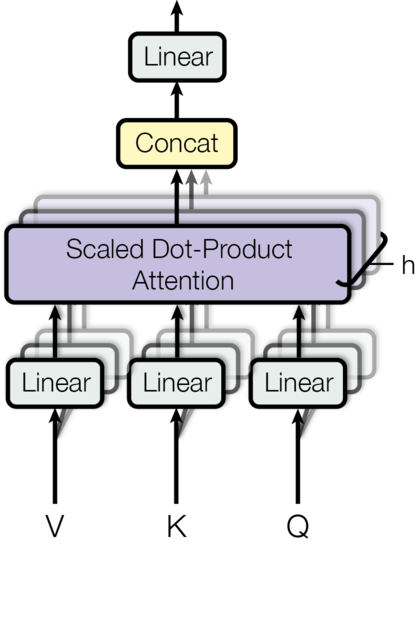

<div>

The fundamental idea though is not different from the self-attention. We just have independent attention modules that do not communicate with each other and then we concatenate their output:


In [28]:
class MultiHeadAttention(nn.Module):
    """Multiple heads of self-attention in parallel """

    def __init__(self, input_size: int, n_head: int, head_size: int, block_size: int, dropout: float = 0.1) -> None:
        super().__init__()
        self.heads = nn.ModuleList(
            [
                AttentionHead(input_size, head_size, block_size, dropout) for _ in range(n_head)
            ]
        )
        self.proj = nn.Linear(input_size, input_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """Forwad pass of the multihead attention module."""
        out = torch.cat([h(inputs) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

### Cleanup

Here we are just going to clean up the code that it makes it easier to add things. See the figure below, where the gray blocks contain individual components and each block is repeated $N$ times.

We are going to create a `TransformerBlock` class and for now put the Multi-Head component inside the block:

<div align="center">

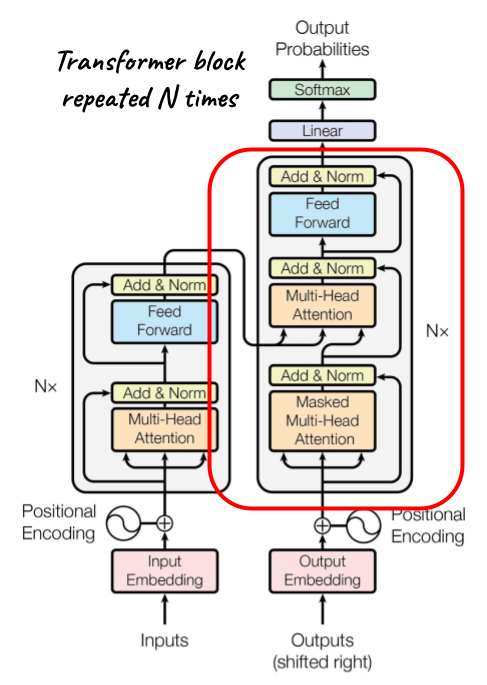

In [29]:
class TransformerBlock(nn.Module):
    """Transformer block.

    This is the basic block that we are going to iterate over.
    For now it only contains the MultiHeadAttention
    """
    def __init__(self, input_size: int, block_size: int, n_head: int, dropout: float = 0.1) -> None:
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(
            input_size=input_size,
            n_head=n_head,
            head_size=head_size,
            block_size=block_size,
            dropout=dropout
        )

    def forward(self, inputs) -> torch.Tensor:
        return self.sa(inputs)

In [30]:
class GPT(nn.Module):
    def __init__(self,
        vocab_size: int, n_embed: int, block_size, n_layer: int, n_head: int, dropout: float = 0.1
    ) -> None:
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        # NEW: adding Transformer blocks to our ngram model
        # A series of `n_layer` blocks stitched sequentially
        blocks = [
            TransformerBlock(
                input_size=n_embed, block_size=block_size, n_head=n_head, dropout=dropout
            ) for _ in range(n_layer)
        ]
        self.blocks = nn.Sequential(*blocks)
        self.lm_head = nn.Linear(n_embed, vocab_size)
        self.block_size = block_size

    def forward(
        self, inputs: torch.Tensor, targets: torch.Tensor | None = None
    ) -> tuple[torch.Tensor, torch.Tensor | None]:
        """Forward pass of the GPT model.

        Args:
            inputs (torch.Tensor): The input to the model
            targets (torch.Tensor): Optionally, the expected output from the model

        Returns:
            logits, loss (torch.Tensor, torch.Tensor | None): The logits from the head of
                the language model, and optionally the loss if the targets are provided
        """
        bsz, seq_len = inputs.shape

        x = self.token_embedding_table(inputs) # (B,T,C)
        # New: propagate the input through every transformer block before the language modeling head
        x = self.blocks(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        loss = None
        if targets is not None:
            bsz, seq_len, vocab_size = logits.shape
            # Flattening the elements in the batch to compute the loss:
            # logits (bsz, seq_len, vocab_size) -> (bsz * seq_len, vocab_size)
            # targets: (bsz, seq_len) -> (bsz * seq_len)
            loss = F.cross_entropy(
                logits.view(bsz * seq_len, vocab_size), targets.view(bsz * seq_len)
            )

        return logits, loss

    @torch.inference_mode
    def generate(self, inputs: torch.Tensor, max_new_tokens: int) -> torch.Tensor:
        """Generation loop."""
        for _ in range(max_new_tokens):
            # Get the predictions, crop the inputs if they are longer than block_size
            logits, loss = self(inputs[:, -self.block_size :])
            # Focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # Sample from the distribution
            inputs_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # Append sampled index to the running sequence
            inputs = torch.cat((inputs, inputs_next), dim=1) # (B, T+1)
        return inputs

    @property
    def device(self) -> torch.device:
        """Determine which device to place the Tensors upon, CPU or GPU."""
        return self.token_embedding_table.weight.device

In [31]:
# Model hyperparameters
vocab_size = len(chara2idx)
block_size = 32
n_embed = 64
n_head = 4
n_layer = 1
dropout = 0.0

# Training hyperparameters
batch_size = 16
num_iterations = 5000
eval_num_batches = 200
eval_interval = 500

# Create the model and move it to the proper device
model = GPT(
    vocab_size=vocab_size,
    n_embed=n_embed,
    block_size=block_size,
    n_layer=n_layer,
    n_head=n_head,
    dropout=dropout
)
model = model.to(device)
print(model)

# create a PyTorch optimizer, think of this as SGD on steroids
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train(
    model=model,
    optimizer=optimizer,
    train_data=train_data,
    eval_data=eval_data,
    batch_size=batch_size,
    block_size=block_size,
    num_iterations=num_iterations,
    eval_interval=eval_interval,
    eval_num_batches=eval_num_batches,
)

GPT(
  (token_embedding_table): Embedding(65, 64)
  (blocks): Sequential(
    (0): TransformerBlock(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x AttentionHead(
            (key): Linear(in_features=64, out_features=16, bias=False)
            (query): Linear(in_features=64, out_features=16, bias=False)
            (value): Linear(in_features=64, out_features=16, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (lm_head): Linear(in_features=64, out_features=65, bias=True)
)
0.024833 M parameters
Iter: 0 train loss 4.2066 val loss 4.1918
Iter: 500 train loss 2.6093 val loss 2.5553
Iter: 1000 train loss 2.4024 val loss 2.4828
Iter: 1500 train loss 2.3351 val loss 2.4441
Iter: 2000 train loss 2.3824 val loss 2.4332
Iter: 2500 train loss 2.4630 val loss 2.4271
Iter: 3000 train loss 

In [32]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=2000)[0].tolist()))


Wince sprcus, btheinioule.
Hes y.


He OLLENToierlertal nd, YRLe y, fowen ET: weane, theeitha h, ther fyat y;
Noufaber tene hen serpit t
Sher g ag itho on is ar! icobldanow!
Cint ca g, hitostoret Mof i y ssodo wapou:
Atovesty! 'Ty We ndes ar temyo ayinclflshid yoor hin weeng me fach m a se lough malofouner mny wanil trstrs lorede safeclddel: omad omesee: t gomor hs m.



Meafor Leetowotle IUGUS:
We! borobur.


Thoow, be ff er in nat ne withaveer s towhidave theamfoit hin antre
She s the iserlin sees othanga ieleng k d isheng d.


Mmel coratoththate an! ayo ISAs s athirul f
RD I: Whend im 'Ralexrsusbut, hiver byoumancope, as e t mur.


Cak; Momulos, INaisood bl yooud m.
ROF oou lcon OMERY:

Mame, fo he stourerimpow, y ghe hat ondasty im t woutit.


PLA:
Nomare ho po k t islbllde is y tighthiss, ke cim d no the Mo napusher m grechamecas,
Sof whancit m htoste ble theepain,
Menim d po dofomaco t it t, d butot shan prthenot gr s,
Fiequsees?


Kes:
ARencodir:
Sa o. our?  garatr'TER:

ct ga 

## Incorporating positional information

<div align="center">

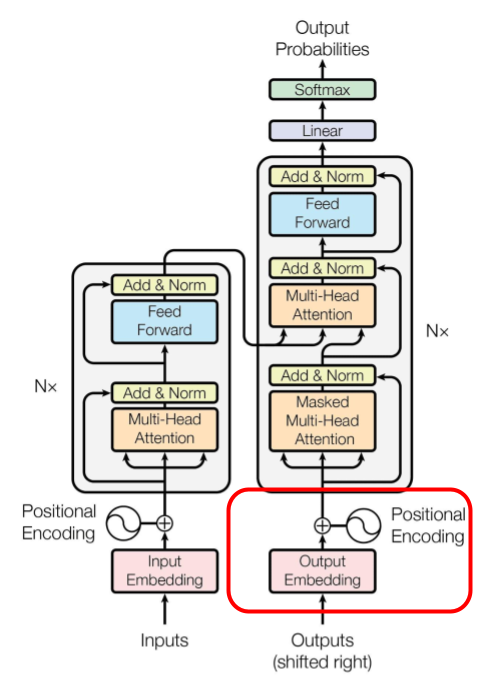

**Question** Why do you think we need positional information in Transformers?

<details>
<summary><strong>Answer</strong></summary>


>We have already stated that the attention operation is **permutation invariant**. The tokens $x_i$ in two sequences $x_1, x_2, x_3$ and $x_3, x_2, x_1$ will have the identical attention weights. But we are doing sequence modeling and so the order matters!


>Think about this example: The sentence "Transformers are better than RNNs" means something completely different than "RNNs are better than Transformers". For this reason, the tokens in the sequence should accommodate some sort of positional information when computing the attention.
</details>

In [33]:
def example_absolute_embeddings() -> alt.Chart:
    max_len = 8
    d_model = 2

    # Lets assume a sequence of 1's as token ids
    input_ids = torch.ones(max_len, dtype=torch.int)

    # Our regular embedding table: mapping token ids to vectors
    embedding_table = nn.Embedding(max_len, d_model)
    input_embeddings = embedding_table(input_ids)

    # The positional embedding table: mapping POSITION of token ids to vectors
    position_embedding_table = nn.Embedding(max_len, d_model)
    position_ids = torch.arange(max_len, dtype=torch.int)
    position_embeddings = position_embedding_table(position_ids)

    # To add positional information, we simply add the two embeddings
    embedding = input_embeddings + position_embeddings

    # Just plot the embedding vector
    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "x": [0, embedding[n, 0].item()],
                    "y": [0, embedding[n, 1].item()],
                    "position": n,
                }
            )
            for n in list(range(max_len))
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="x", y="y", color="position:N")
        .interactive()
    )

show_example(example_absolute_embeddings)

alt.Chart(...)

#### Exercise 2: Implement the absolute positional embeddings in the GPT module:

In [34]:
class GPT(nn.Module):
    def __init__(self,
        vocab_size: int, n_embed: int, block_size, n_layer: int, n_head: int, dropout: float = 0.1
    ) -> None:
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        # NEW: ADD a new variable here named `position_embedding_table`
        # initialized as an nn.Embedding
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        blocks = [
            TransformerBlock(
                input_size=n_embed, block_size=block_size, n_head=n_head, dropout=dropout
            ) for _ in range(n_layer)
        ]
        self.blocks = nn.Sequential(*blocks)
        self.lm_head = nn.Linear(n_embed, vocab_size)
        self.block_size = block_size

    def forward(
        self, inputs: torch.Tensor, targets: torch.Tensor | None = None
    ) -> tuple[torch.Tensor, torch.Tensor | None]:
        """Forward pass of the GPT model.

        Args:
            inputs (torch.Tensor): The input to the model
            targets (torch.Tensor): Optionally, the expected output from the model

        Returns:
            logits, loss (torch.Tensor, torch.Tensor | None): The logits from the head of
                the language model, and optionally the loss if the targets are provided
        """
        bsz, seq_len = inputs.shape

        tok_emb = self.token_embedding_table(inputs) # (B,T,C)
        # NEW: create the positional embeddings here
        position_input_ids = torch.arange(seq_len, device=self.device)
        pos_emb = self.position_embedding_table(position_input_ids) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        loss = None
        if targets is not None:
            bsz, seq_len, vocab_size = logits.shape
            # Flattening the elements in the batch to compute the loss:
            # logits (bsz, seq_len, vocab_size) -> (bsz * seq_len, vocab_size)
            # targets: (bsz, seq_len) -> (bsz * seq_len)
            loss = F.cross_entropy(
                logits.view(bsz * seq_len, vocab_size), targets.view(bsz * seq_len)
            )

        return logits, loss

    @torch.inference_mode
    def generate(self, inputs: torch.Tensor, max_new_tokens: int) -> torch.Tensor:
        for _ in range(max_new_tokens):
            # Get the predictions, crop the inputs if they are longer than block_size
            logits, loss = self(inputs[:, -self.block_size :])
            # Focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # Sample from the distribution
            inputs_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # Append sampled index to the running sequence
            inputs = torch.cat((inputs, inputs_next), dim=1) # (B, T+1)
        return inputs

    @property
    def device(self) -> torch.device:
        """Determine which device to place the Tensors upon, CPU or GPU."""
        return self.token_embedding_table.weight.device

In [35]:
# Model hyperparameters
vocab_size = len(chara2idx)
block_size = 32
n_embed = 64
n_head = 4
n_layer = 1
dropout = 0.0

# Training hyperparameters
batch_size = 16
num_iterations = 5000
eval_num_batches = 200
eval_interval = 500

# Create the model and move it to the proper device
model = GPT(
    vocab_size=vocab_size,
    n_embed=n_embed,
    block_size=block_size,
    n_layer=n_layer,
    n_head=n_head,
    dropout=dropout
)
model = model.to(device)
print(model)

# create a PyTorch optimizer, think of this as SGD on steroids
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train(
    model=model,
    optimizer=optimizer,
    train_data=train_data,
    eval_data=eval_data,
    batch_size=batch_size,
    block_size=block_size,
    num_iterations=num_iterations,
    eval_interval=eval_interval,
    eval_num_batches=eval_num_batches,
)

GPT(
  (token_embedding_table): Embedding(65, 64)
  (position_embedding_table): Embedding(32, 64)
  (blocks): Sequential(
    (0): TransformerBlock(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x AttentionHead(
            (key): Linear(in_features=64, out_features=16, bias=False)
            (query): Linear(in_features=64, out_features=16, bias=False)
            (value): Linear(in_features=64, out_features=16, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (lm_head): Linear(in_features=64, out_features=65, bias=True)
)
0.026881 M parameters
Iter: 0 train loss 4.1033 val loss 4.0695
Iter: 500 train loss 2.5906 val loss 2.5456
Iter: 1000 train loss 2.4118 val loss 2.3925
Iter: 1500 train loss 2.3567 val loss 2.3220
Iter: 2000 train loss 2.1472 val loss 2.2753
Iter: 2500 train lo

In [36]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=2000)[0].tolist()))


The as multake bitaring the sle feave!
Ovight to whit ouch menf you ome.

On be.

Ay to like, ing canjer-hy danese 'lth fige thin to mysm:
Nigro, wist noth the not in wayou's ther it's thy nor cup eveunn
He shir,
D;
And f hat Caip chy cuslahe loves

The!

AS O of istr.

BULNGSEHRICHES DO:
BeRentio sprou.

KANrend heand ind juld le
Wo, aper, I hingre
noe kird thy show herd, and of encerand mung,
Ow at:
O the;, and hou my shil hos my his a thys shach quee man ary hou, tinh kis hou hou wit Kineld graltizeet you someardsset--
Ineg.

And WAS:
BeUnly agand it:
He in the wite you, I getseo that'twich lath saand opes noth be to my to to to thee that;
Ard wesll forde'd whit haink.
Fer's lower to---ksand me, fur hat Ilamy eme Imad
Lors.

ESINIO:
Moth theateawend sher.

Do man:
Ium I com molt. Froy Cal Coutir, stio staus shath shave ood,
He this is laffil' sonesman dif Wice;
And were not myrie the meis sull poulf he the thaves gar orue hil'se ood oingsencesing llad tracontedomperseld Rend mae th

## Communication followed by computation

<div align="center">

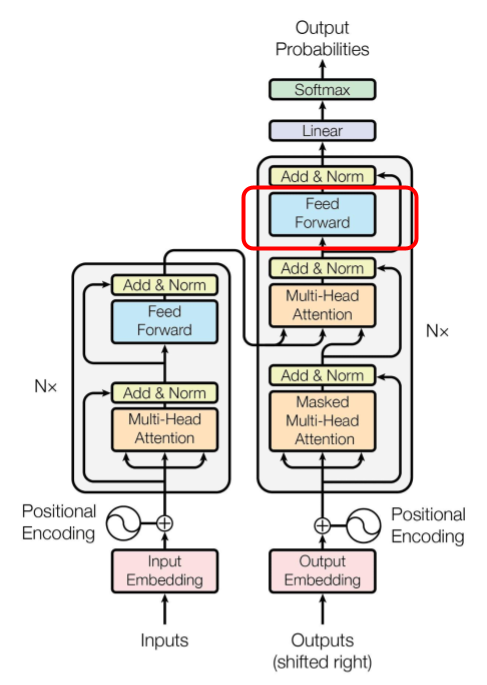

Before we had the MultiHead attention component within the Transformer block. We trained our model, and we saw that the performance was actually worse.

One of the reasons for this behavior is that we are basically going way too fast to compute the logits. Recall that the attention mechanism is a communication process, between the tokens. While the tokens looked at each other they did not have enough time to *process* the information they saw. And so the feedforward component is a *buffering stage*, where we add some computation to allow the tokens to process the information they found.

Typically this feedforward is a simple MLP composed of two layers where we expand the hidden dim by a factor of 4:

In [37]:
class FeedFoward(nn.Module):
    """Simple linear layer followed by a non-linearity """

    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 4 * input_size),
            nn.ReLU(),
            nn.Linear(4 * input_size, input_size),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [38]:
class TransformerBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, input_size: int, block_size: int, n_head: int, dropout=0.1):
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(
            input_size=input_size,
            n_head=n_head,
            head_size=head_size,
            block_size=block_size,
            dropout=dropout
        )

        # New: adding computation to our transformer block
        self.ffwd = FeedFoward(n_embed)

    def forward(self, x):
        x = self.sa(x)
        # New: after tokens communicate we add computation
        x = self.ffwd(x)
        return x

In [39]:
# Model hyperparameters
vocab_size = len(chara2idx)
block_size = 32
n_embed = 64
n_head = 4
n_layer = 1
dropout = 0.0

# Training hyperparameters
batch_size = 16
num_iterations = 5000
eval_num_batches = 200
eval_interval = 500

# Create the model and move it to the proper device
model = GPT(
    vocab_size=vocab_size,
    n_embed=n_embed,
    block_size=block_size,
    n_layer=n_layer,
    n_head=n_head,
    dropout=dropout
)
model = model.to(device)
print(model)

# create a PyTorch optimizer, think of this as SGD on steroids
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train(
    model=model,
    optimizer=optimizer,
    train_data=train_data,
    eval_data=eval_data,
    batch_size=batch_size,
    block_size=block_size,
    num_iterations=num_iterations,
    eval_interval=eval_interval,
    eval_num_batches=eval_num_batches,
)

GPT(
  (token_embedding_table): Embedding(65, 64)
  (position_embedding_table): Embedding(32, 64)
  (blocks): Sequential(
    (0): TransformerBlock(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x AttentionHead(
            (key): Linear(in_features=64, out_features=16, bias=False)
            (query): Linear(in_features=64, out_features=16, bias=False)
            (value): Linear(in_features=64, out_features=16, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
          (3): Dropout(p=0.0, inplace=False)
        )
      )
    )
  )
  (lm_head): Linear(in_features=64, out_features=65, bia

In [40]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=2000)[0].tolist()))


To de'd preput my ass comed deebleaver's bsedim prain anding come and, aw is for thluch you will
Your liat liver thusbe fathen prethere confiem him
ion then Courishnd giving preI conced's all.

DUKY VINCICK:
Sin joy Clifed by thanks that on what's an?' Bervain hedn I it nield'Y, Besting
I stableegs, I'll can Con reas dgo of him thy; a greath, Striune ithe thou seed mean:
I'lwind cound of takes seaps, me'll am bactortable, leasir,
You'lew of my heannot purid make is that,
He wild as the chars and sher's; and of prowres:
As?

Yout falace; the as mown
I shald world how one
everer thith shale, so sor frave griend what low anders seach self,
Thou, dear least of wark drued.
We Yet were, adf his.
Cece.

PAICINGHAM:
Uwrongal havembleng,
Ao not the preshalbuld hone, in the not is and encluses' gent?

First the gare! all fare his?

COMENIU NIO:
Go, kided, whas Than pricule  boad'n the him,
And, wherenentry I phith speak way trout brough
Tup, but facowndern was werefor: I when shallong me, sin m

## Scaling up the model

Lets move from a model with one Transformer Block to four. If you actually try to run this, you will notice that the model is not very good. In fact it performs worse than our previous model containing only one Transformer block!



In [41]:
# @title
# torch.manual_seed(42)

vocab_size = len(chara2idx)
# Model hyperparameters
block_size = 32
n_embed = 64
n_head = 4
n_layer = 4
dropout = 0.0

# Training hyperparameters
batch_size = 16
num_iterations = 5000
eval_num_batches = 200
eval_interval = 500
# device = "cuda" if torch.cuda.is_available() else "cpu"


# Create the model and move it to the proper device
model = GPT(
    vocab_size=vocab_size,
    n_embed=n_embed,
    block_size=block_size,
    n_layer=n_layer,
    n_head=n_head,
    dropout=dropout
)
model = model.to(device)
print(model)

# create a PyTorch optimizer, think of this as SGD on steroids
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train(
    model=model,
    optimizer=optimizer,
    train_data=train_data,
    eval_data=eval_data,
    batch_size=batch_size,
    block_size=block_size,
    num_iterations=num_iterations,
    eval_interval=eval_interval,
    eval_num_batches=eval_num_batches,
)

GPT(
  (token_embedding_table): Embedding(65, 64)
  (position_embedding_table): Embedding(32, 64)
  (blocks): Sequential(
    (0): TransformerBlock(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x AttentionHead(
            (key): Linear(in_features=64, out_features=16, bias=False)
            (query): Linear(in_features=64, out_features=16, bias=False)
            (value): Linear(in_features=64, out_features=16, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
          (3): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (1): TransformerBlock(
      (sa): MultiHeadAttention(
 

In [42]:
# @title
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=2000)[0].tolist()))


'aiov asfredw-,m tseeana gd pbkeedisoby s rr ae
Rb awai ir iart n eao: : ns ayggsn   .e onroL,qi hOewnloey ir  id qai rrnlMeoetr
  hfh rIoosan eoemtwayiaern totpsia oh bga nue
lnoSaeecesa  rhfoics mtnunooaoceea:ayew,iedu
wad
htlfm rlr rehhbntuaoinude;ae
uam n,o 
hwwor ,r  rn
ian  nb eeaseromnt yr a toeet h
 tornt  dodb weir,tcsmgreirhreeo
:Ispoau rea yie. geee ar  ed ele p iyeco rn
 r e m et ,oa afntosHmodg abrn id
e t o.
ntg
uoIoptmmrameGatm ed  ee ltae' !ehurrerc dnrnniSsy,y wour
ogapi t dserdyne    o et shoafo tcstaea  n hntHl    tapem
 h  ea
ria i   ea eoiondsddn, p  o y.
heroMRheunE yrhyeIatwa tbla tneps
ivamsrhta
l iglrep rl Cbnng s'atsireoyndstn ;n mutiulen omogh'a  nte.GHAim,o
uhsn on,shyUrda
eetoereddl ivutee;eeteneio meannighkri
Tdsm  a  h  yaEsseTtf dhhhslneha teee s  u
 wsri, bl fd ndua rnr styd d tr ye reus laattlraadsdouroucnp
info biaaeneienedn
ur.ete,ddhsTBrule e Saigmt r eraoTp aisektruassysfru d
tebl buao rat ot  ehr o aastuufsfnto 
s,Tby 'n e  n hs  ooso rsn oatMtha

## To be or not to be, are we actually making things worse?

We are starting to actually get a pretty deep neural network, how exciting!

However, it feels like going backwards, we implemented all of these components, and after scaling up the model we are actually getting worse results than our baseline ngram model.

The issue is that deep neural networks are powerful but are very tricky to optimize! So what are we missing?

There are two optimizations that help with the optimization both of which actually are older than the Transformer paper!

1. Residual Connections
2. Layer Normalization

### Residual Connections

Notice in the figure below that there is a yellow component that we have not implemented yet.  This component accepts as input:

1. The output of the feedfoward component in blue
2. The input of that feedfoward component, see the connecting arrow on the ride side that bypasses the feedfoward component.



<div align="center">

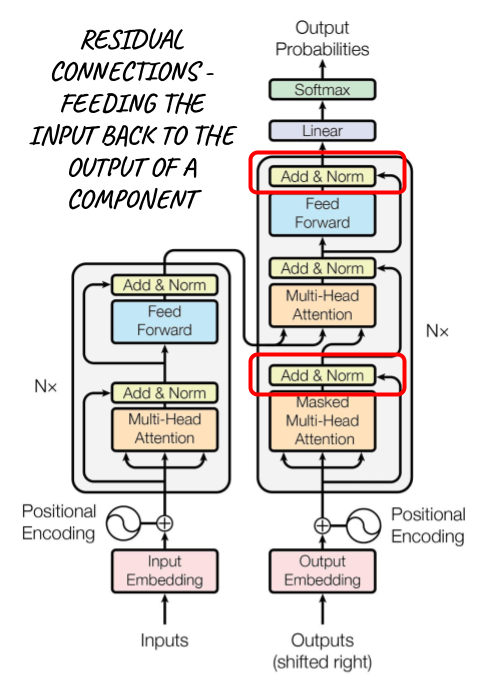

This connection is called a residual or skip connection and traces back to the [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385) paper. What this connection basically means that is that we have some input data that are passing through a component, and then we add that data to the output of the component.

A more clean visualization adopted from [here](https://link.springer.com/article/10.1007/s10489-021-02858-6) is shown below:


<div align="center">


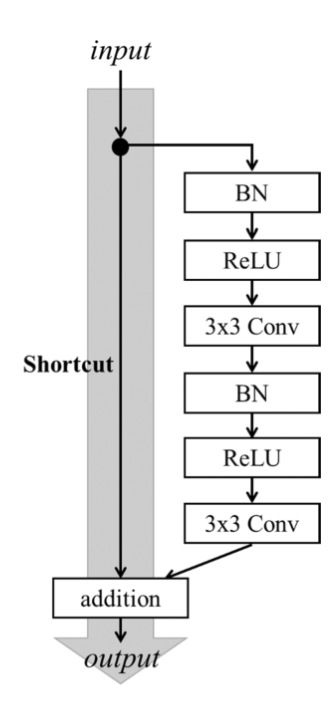





In the above figure the computation within the network happens from top to bottom, and we have this shortcut from the inputs directly into the outputs.

We are free to do branch out form the shortcut to do some computation (doesn't matter what!) and then hop into the shortcut path via addition.


Now the reason this is useful is that we can go from the inputs to the outputs via the addition operation, and so during back propagation the addition operation will distribute weights equally through both branches.

As a result the gradients from the targets will flow smoothly all the way back into the input!
So this shortcut acts as a gradient highway, that goes directly from the output to the input unimpeded.


### Layer Normalization

The second innovation that helps with optimization is the Layer Norm (see the `Norm` entry in the yellow component).

Layer Normalization was introduced a while ago in this [paper](https://arxiv.org/pdf/1607.06450) and is already implemented in [PyTorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html). Given an input $x$ this component normalizes across the feature dimension:


\begin{equation}
y = \frac{x - E[x]}{\sqrt{Var[x] + \epsilon}} * \gamma + \beta
\end{equation}



Layer Normalization is very similar to [Batch Normalization](https://arxiv.org/abs/1502.03167), we are not going to fully explain how batch normalization works but the high-level idea is that we normalize every column in the batch to ensure that it is gaussian with zero mean and unit variance. This normalization effect prevents saturated activations that bottleneck the gradient flow in the network:

In [43]:
class BatchNorm1d(nn.Module):
  def __init__(self, hidden_size: int, eps: float = 1e-5) -> None:
    super().__init__()
    self.eps = eps
    self.gamma = torch.ones(hidden_size)
    self.beta = torch.zeros(hidden_size)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """Forward pass of BatchNorm1d."""
    # compute mean & variance
    xmean = x.mean(0, keepdim=True)
    xvar = x.var(0, keepdim=True)
    # normalize to unit variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    out = self.gamma * xhat + self.beta
    return out

In [44]:
torch.manual_seed(42)
hidden_size = 100
batch_norm = BatchNorm1d(hidden_size=hidden_size)

x = torch.randn(32, hidden_size)
y = batch_norm(x)
# Approximately zero mean and unit variance over one feature across all batch inputs
print(y[:, 0].mean(), y[:, 0].std())

tensor(1.4901e-08) tensor(1.0000)


Batch Normalization, standarizes the input across columns (features) while Layer Normalization standarizes the rows:


<div align="center">

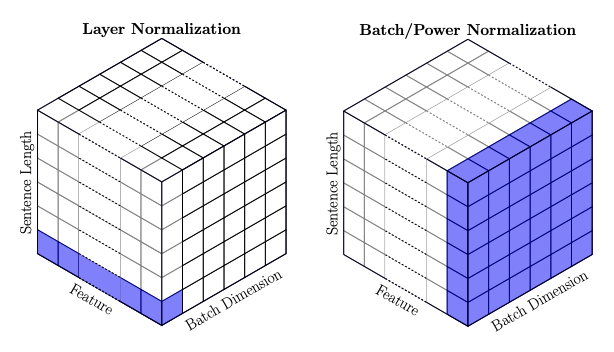

In [45]:
class LayerNorm1d(nn.Module):
  def __init__(self, hidden_size: int, eps: float = 1e-5) -> None:
    super().__init__()
    self.eps = eps
    self.gamma = torch.ones(hidden_size)
    self.beta = torch.zeros(hidden_size)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """Forward pass of BatchNorm1d."""
    # compute mean & variance over the rows
    xmean = x.mean(1, keepdim=True)
    xvar = x.var(1, keepdim=True)
    # normalize to unit variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    out = self.gamma * xhat + self.beta
    return out

In [46]:
layer_norm = LayerNorm1d(hidden_size=hidden_size)

y = layer_norm(x)
# Approximately zero mean and unit variance over all features across one batch input
print(y[0, : ].mean(), y[0, :].std())

tensor(-2.3842e-08) tensor(1.0000)


### Putting both together

Lets put both residual connections and layer normalization components in our model.

A tiny modification that we are going to do here is that based on the Transformer figure the `Add & Norm` component is applied AFTER the transformation, i.e the attention or the feedforward component. What is accepted nowadays is to apply the residual connection and the normalization BEFORE the transformation (see conclusions for a fun fact about this)

In [47]:
class TransformerBlock(nn.Module):
    """Transformer block"""

    def __init__(self, input_size: int, block_size: int, n_head: int, dropout: float = 0.1):
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(
            input_size=input_size,
            n_head=n_head,
            head_size=head_size,
            block_size=block_size,
            dropout=dropout,
        )
        self.ffwd = FeedFoward(n_embed)
        # NEW: adding layer normalization!
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        # NEW: adding residual connections and layer normalization!
        # We fork off and do the MHA then add the result back to the input
        x = x + self.sa(self.ln1(x))
        # We fork off and do the computation then add the result back to the input
        x = x + self.ffwd(self.ln2(x))
        return x


In [48]:
class GPT(nn.Module):
    def __init__(self,
        vocab_size: int, n_embed: int, block_size, n_layer: int, n_head: int, dropout: float = 0.1
    ) -> None:
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        blocks = [
            TransformerBlock(
                input_size=n_embed, block_size=block_size, n_head=n_head, dropout=dropout
            ) for _ in range(n_layer)
        ]
        self.blocks = nn.Sequential(*blocks)
        # NEW: final layer norm
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)
        self.block_size = block_size

    def forward(
        self, inputs: torch.Tensor, targets: torch.Tensor | None = None
    ) -> tuple[torch.Tensor, torch.Tensor | None]:
        """Forward pass of the GPT model.

        Args:
            inputs (torch.Tensor): The input to the model
            targets (torch.Tensor): Optionally, the expected output from the model

        Returns:
            logits, loss (torch.Tensor, torch.Tensor | None): The logits from the head of
                the language model, and optionally the loss if the targets are provided
        """
        bsz, seq_len = inputs.shape

        tok_emb = self.token_embedding_table(inputs) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(seq_len, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        loss = None
        if targets is not None:
            bsz, seq_len, vocab_size = logits.shape
            # Flattening the elements in the batch to compute the loss:
            # logits (bsz, seq_len, vocab_size) -> (bsz * seq_len, vocab_size)
            # targets: (bsz, seq_len) -> (bsz * seq_len)
            loss = F.cross_entropy(
                logits.view(bsz * seq_len, vocab_size), targets.view(bsz * seq_len)
            )

        return logits, loss

    @torch.inference_mode
    def generate(self, inputs: torch.Tensor, max_new_tokens: int) -> torch.Tensor:
        for _ in range(max_new_tokens):
            # Get the predictions, crop the inputs if they are longer than block_size
            logits, loss = self(inputs[:, -self.block_size :])
            # Focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # Sample from the distribution
            inputs_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # Append sampled index to the running sequence
            inputs = torch.cat((inputs, inputs_next), dim=1) # (B, T+1)
        return inputs

    @property
    def device(self) -> torch.device:
        """Determine which device to place the Tensors upon, CPU or GPU."""
        return self.token_embedding_table.weight.device


In [49]:
# Model hyperparameters
vocab_size = len(chara2idx)
block_size = 32
n_embed = 64
n_head = 4
n_layer = 4
dropout = 0.0

# Training hyperparameters
batch_size = 16
num_iterations = 5000
eval_num_batches = 200
eval_interval = 500

# Create the model and move it to the proper device
model = GPT(
    vocab_size=vocab_size,
    n_embed=n_embed,
    block_size=block_size,
    n_layer=n_layer,
    n_head=n_head,
    dropout=dropout
)
model = model.to(device)
print(model)

# create a PyTorch optimizer, think of this as SGD on steroids
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train(
    model=model,
    optimizer=optimizer,
    train_data=train_data,
    eval_data=eval_data,
    batch_size=batch_size,
    block_size=block_size,
    num_iterations=num_iterations,
    eval_interval=eval_interval,
    eval_num_batches=eval_num_batches,
)

GPT(
  (token_embedding_table): Embedding(65, 64)
  (position_embedding_table): Embedding(32, 64)
  (blocks): Sequential(
    (0): TransformerBlock(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x AttentionHead(
            (key): Linear(in_features=64, out_features=16, bias=False)
            (query): Linear(in_features=64, out_features=16, bias=False)
            (value): Linear(in_features=64, out_features=16, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
          (3): Dropout(p=0.0, inplace=False)
        )
      )
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)


In [50]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=2000)[0].tolist()))



DUKE OLIO:
Sir, you worthilk.

Biy, this not soufh death, Lew like of fleed?

Nurse:
Which'd you shall one out woulds.
You is vould depost me ses, every grievets by younget none! very Belizes! whereater, and so moven of pot nuts.
Thirds' to upon flaintrings, and and ageined? which pripold,
Would it I know our Worthir'd from quaking
Is sie yonies mell: yout tysures love,
As you all numbly of Augvery; thought
We himsethip you? chanted tree commont a talquast gueles.
What I will mets ext the noneds io give?

QUEEN RIZABETH:
I what bled.
He had at it, in the revenge
An friends, will bech; here's aboward
Or night distizen out flriey o' chapt; I done Ling gone,
Or friefull for go your forful gous Gods, it prayikes bidy you mar.

Shephere:
I way'st chisten, free rown.

LEONTS:
So is yet at us by so, gonpy beggently trorge.
You manst they forwick mon; at to dreny you
of weep up markeignies, not, whom I lose a ban out pacies; in what, or dign pargition urpot at of! now? being death,
Dish upon

## Conclusion

In this lab we implemented the state-of-the-art backbone that is used in most NLP as well computer vision, and audio processing applications.

- We deep dived into the attention mechanism to understand how the data-dependent weights are coming alive in sequence processing.
- Because the attention is a permutation invariant operation, we also implemented positional information so that the position of the token in a sequence matters
- Finally, we briefly illustrated the two optimization tricks -- residual connections, and layer normalization, that actually preceed the transformer but make the optimization of deep models feasible.

Congratulations! You should be proud by reaching this point, it was certaintly not easy 😀


The evolution from traditional sequence-to-sequence models to transformers represents a fundamental shift in how we approach sequential data processing, moving from the inherently serial nature of RNNs and LSTMs—which process inputs one timestep at a time and generate outputs through sequential decoding—to a revolutionary parallel processing paradigm enabled by clever mathematical tricks based on linear algebra in self-attention. This architectural breakthrough allows transformers to process entire sequences simultaneously during training, dramatically reducing computational time while capturing relationships between any two positions in a sequence directly, regardless of their distance, eliminating the information bottleneck problems that plagued earlier encoder-decoder architectures. The impact extends far beyond efficiency gains: this parallel processing capability has enabled scaling to much larger models and datasets, ultimately leading to the breakthrough language models and multimodal systems we see today, proving that the most powerful solutions often come from reimagining how information should flow through our models rather than simply optimizing existing sequential approaches.

### What has changed from the original Transformer architecture?


#### Pre-layernorm vs Post-layernorm
If you have been paying attention (pun intended) we did not follow the exact implementation of the vanilla transformer. The original approach follows what we now refer to as "post-layernorm", where the layernorm is applied after encoding. By contrast, in "pre-layernorm" we apply layer normalization before encoding. This was actually a mistake by the authors where they fixed the code after the release of the paper (see details [here](https://github.com/tensorflow/tensor2tensor/commit/f5c9b17e617ea9179b7d84d36b1e8162cb369f25))


In 2020 the paper [On Layer Normalization in the Transformer Architecture](https://proceedings.mlr.press/v119/xiong20b) further confirmed the superiority of the pre-layer norm over the post-layer norm approach.


#### Positional Embeddings
The vanilla Transformer adds sinusoidal positional information at the token level, where the position of a token is determined by periodic sine and cosine wave functions. In this lab we used absolute embeddings, where we embedded the exact position of a token using an embedding table.

If you inspect the embedding figure, these types of embeddings significantly modify both the magnitude and the angle of a token embedding based on the position in the sequence. Additionally, they can make the extrapolating inference to longer sequences challenging. For these reasons, most modern models [Gemma](https://arxiv.org/abs/2403.08295), [LLaMA](https://arxiv.org/abs/2302.13971), or [Mistral](https://arxiv.org/abs/2310.06825) have pivoted from this design choice by incorporating the positional information at the attention mechanism.


The paper [Train Short, Test Long: Attention with Linear Biases Enables Input Length Extrapolation](https://openreview.net/forum?id=R8sQPpGCv0) was one of the first papers to model positional information at the attention level by introducing the ALiBI embeddings, where the positional bias between the query-key attention scores proportional to their distance.


[Roformer: Enhanced transformer with rotary position embedding](https://www.sciencedirect.com/science/article/abs/pii/S0925231223011864) introduces RoPE embeddings which are now being applied to most Transformer models that basically rotates the query and key vectors based on their position in the sequence.


#### Encoder-Decoder vs Decoder-only models
In this lab we implemented a decoder-only model, though the original paper proposes an encoder-decoder model.
While in principle encoder-decoder models perform on par with decoder-only models, the latter are increasingly becoming the de facto option for modern language models.
When training models at scale with thousands of documents and trillions of words, computational efficiency is key. Decoder-only offers a solution to this problem because they allow practitioners to divide the model on multiple GPUs in an easier way compared to encoder-decoder models which are composed of multiple Transformers.

---
### Alternative architectures that compete with transformers


While Transformers have been established as the core block for most applications, there are some works that try to adopt architectures without the attention mechanism. The latter, while powerful, introduces substantial complexity particularly in tasks that require processing very long sequences. To address this many works try to scale up recurrent models that rival Transformers both in raw performance as well as computational overhead. We provide a few references for those who are interested:


* [Hungry Hungry Hippos: Towards Language Modeling with State Space Models](https://openreview.net/forum?id=COZDy0WYGg)
* [RWKV: Reinventing RNNs for the Transformer Era](https://openreview.net/forum?id=7SaXczaBpG)
* [Mamba: Linear-Time Sequence Modeling with Selective State Spaces](https://arxiv.org/pdf/2312.00752)
* [Transformers are SSMs: Generalized Models and Efficient Algorithms Through Structured State Space Duality](https://arxiv.org/abs/2405.21060)

<a name="section:acknowledgement"></a>
# Acknowledgements

This notebook is based on existing learning material for Transformers including:

* [The Annotated Transformer](https://nlp.seas.harvard.edu/annotated-transformer/)
* Andrej Karpathy's tutorial on Transformers: [Let's build the GPT Tokenizer](https://youtu.be/zduSFxRajkE)
* [AthNLP summer school material](https://github.com/athnlp)